## Setup:

In [32]:
import os
import json
from pathlib import Path
from collections import Counter
import pandas as pd

# --- CONFIG ---
BASE_PATH = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/llm_subtopic")
MODES = ["single_label", "multi_label"]

# Note: Health becomes part of the Lifestyle
LABEL_MAP = {
    "Health": "Lifestyle"
}



records = []

for mode in MODES:
    mode_path = BASE_PATH / mode
    topic_files = sorted(mode_path.glob("topic_*.json"))
    
    for file in topic_files:
        with open(file, "r") as f:
            data = json.load(f)
            topic_id = data.get("topic", file.stem.replace("topic_", ""))
            samples = data.get("samples", [])

            # Collect and remap labels
            all_labels = []
            for s in samples:
                label_field = s.get("gpt_label", "").strip()
                if not label_field:
                    continue
                labels = [LABEL_MAP.get(l.strip(), l.strip()) for l in label_field.split(",")]
                all_labels.extend(labels)

            label_counts = Counter(all_labels)
            total_label_count = sum(label_counts.values())
            assigned_label = label_counts.most_common(1)[0][0] if label_counts else "Unlabeled"
            diversity = len(label_counts)
            coherence = (label_counts[assigned_label] / total_label_count) if total_label_count > 0 else 0.0

            records.append({
                "mode": mode,
                "file": file.name,
                "topic": topic_id,
                "assigned_label": assigned_label,
                "diversity": diversity,
                "coherence": round(coherence, 3),
                "total_samples": len(samples),
                "label_counts": dict(label_counts)  # KEEP THIS
            })

# --- Create DataFrame ---
df_summary = pd.DataFrame(records)

# Expand label_counts into separate columns (but keep original column too)
label_df = df_summary["label_counts"].apply(pd.Series).fillna(0).astype(int)
df_final = pd.concat([df_summary, label_df], axis=1)  # DO NOT DROP label_counts

# Sort for readability
df_final = df_final.sort_values(by=["mode", "topic"])

# Preview
print(df_final.head())

# Optional: save
df_final.to_csv("llm_cluster_summary.csv", index=False)


            mode             file  topic assigned_label  diversity  coherence  \
98   multi_label  topic_0000.json      0       Politics          9      0.457   
99   multi_label  topic_0001.json      1       Politics         14      0.390   
100  multi_label  topic_0002.json      2         Fossil          7      0.390   
101  multi_label  topic_0003.json      3      Renewable         11      0.211   
102  multi_label  topic_0004.json      4       Politics         10      0.513   

     total_samples                                       label_counts  \
98              20  {'Politics': 16, 'Activism': 7, 'Disaster': 4,...   
99              20  {'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...   
100             20  {'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...   
101             20  {'Lifestyle': 2, 'Waste': 7, 'Renewable': 8, '...   
102             20  {'Politics': 20, 'Disaster': 2, 'Renewable': 1...   

     Politics  Activism  ...  Climate Disinformation  Wildlife  \
98      

In [30]:
df_summary

,mode,file,topic,assigned_label,diversity,coherence,total_samples,label_counts
0,single_label,topic_0000.json,0,Politics,4,0.750,20,"{'Politics': 15, 'Activism': 1, 'Nature': 1, '..."
1,single_label,topic_0001.json,1,Politics,5,0.750,20,"{'Renewable': 2, 'Politics': 15, 'Disaster': 1..."
2,single_label,topic_0002.json,2,Fossil,3,0.700,20,"{'Fossil': 14, 'Politics': 5, 'Nature': 1}"
3,single_label,topic_0003.json,3,Renewable,8,0.300,20,"{'Lifestyle': 2, 'Nuclear': 1, 'Renewable': 6,..."
4,single_label,topic_0004.json,4,Politics,5,0.800,20,"{'Politics': 16, 'Fossil': 1, 'Agriculture': 1..."
...,...,...,...,...,...,...,...,...
191,multi_label,topic_1044.json,1044,Politics,6,0.459,20,"{'Politics': 17, 'Renewable': 9, 'Weather': 2,..."
192,multi_label,topic_1045.json,1045,Nature,10,0.366,20,"{'Disaster': 1, 'Nature': 15, 'Waste': 4, 'Agr..."
193,multi_label,topic_1046.json,1046,Nature,13,0.296,20,"{'Nature': 8, 'Renewable': 3, 'Lifestyle': 5, ..."
194,multi_label,topic_1047.json,1047,Renewable,5,0.591,20,"{'Renewable': 13, 'Activism': 1, 'Nature': 5, ..."


In [49]:
# 1. Compute global label frequencies across all topics
label_columns = df_final.columns.difference(["mode", "file", "topic", "assigned_label", "diversity", "coherence", "total_samples", "label_counts"])
global_counts = df_final[label_columns].sum().sort_values(ascending=False)

hardcoded_exclude = [
    "Uncategorized", "N/A", "Air Quality", "Other", "Nuclear", "Environment",
    "New Category", "Not classified", "Inappropriate", "Water", "Not climate-related"
]
labels_to_keep = [lbl for lbl in labels_to_keep if lbl not in hardcoded_exclude]



# 3. Create a filtered DataFrame with only common labels
df_filtered = df_final.drop(columns=[col for col in label_columns if col not in labels_to_keep])

# 4. Keep full metadata columns
cols_to_preserve = ["mode", "file", "topic", "assigned_label", "diversity", "coherence", "total_samples", "label_counts"]
df_filtered = df_filtered[cols_to_preserve + labels_to_keep]

# Optional: sort
df_filtered = df_filtered.sort_values(by=["mode", "topic"])

# Output
print("Labels retained (>=10 uses):", labels_to_keep)
print(df_filtered.head())

df_filtered.to_csv("LLM_Clusters_Topic_Assignment.csv")


Labels retained (>=10 uses): ['Politics', 'Renewable', 'Nature', 'Activism', 'Fossil', 'Waste', 'Lifestyle', 'Weather', 'Disaster', 'Agriculture', 'Transportation', 'Electricity', 'Construction', 'Climate', 'Technology']
            mode             file  topic assigned_label  diversity  coherence  \
98   multi_label  topic_0000.json      0       Politics          9      0.457   
99   multi_label  topic_0001.json      1       Politics         14      0.390   
100  multi_label  topic_0002.json      2         Fossil          7      0.390   
101  multi_label  topic_0003.json      3      Renewable         11      0.211   
102  multi_label  topic_0004.json      4       Politics         10      0.513   

     total_samples                                       label_counts  \
98              20  {'Politics': 16, 'Activism': 7, 'Disaster': 4,...   
99              20  {'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...   
100             20  {'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...   


## Assignment of GPT Label to BERTopic Clusters along with stats for further analysis

In [50]:
df = pd.read_csv("LLM_Clusters_Topic_Assignment.csv")
df.head(50)

,Unnamed: 0,mode,file,topic,assigned_label,diversity,coherence,total_samples,label_counts,Politics,...,Waste,Lifestyle,Weather,Disaster,Agriculture,Transportation,Electricity,Construction,Climate,Technology
0,98,multi_label,topic_0000.json,0,Politics,9,0.457,20,"{'Politics': 16, 'Activism': 7, 'Disaster': 4,...",16,...,0,2,1,4,0,0,0,0,0,0
1,99,multi_label,topic_0001.json,1,Politics,14,0.390,20,"{'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...",16,...,0,2,1,2,0,1,1,0,1,0
2,100,multi_label,topic_0002.json,2,Fossil,7,0.390,20,"{'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...",15,...,0,3,0,0,0,0,0,1,0,0
3,101,multi_label,topic_0003.json,3,Renewable,11,0.211,20,"{'Lifestyle': 2, 'Waste': 7, 'Renewable': 8, '...",4,...,7,2,0,0,0,0,4,1,0,1
4,102,multi_label,topic_0004.json,4,Politics,10,0.513,20,"{'Politics': 20, 'Disaster': 2, 'Renewable': 1...",20,...,0,0,5,2,1,0,0,0,1,0
5,103,multi_label,topic_0005.json,5,Transportation,9,0.429,20,"{'Politics': 4, 'Renewable': 8, 'Transportatio...",4,...,1,6,0,1,0,18,1,1,0,0
6,104,multi_label,topic_0006.json,6,Fossil,10,0.333,20,"{'Renewable': 7, 'Electricity': 3, 'Fossil': 1...",8,...,1,0,0,0,0,2,3,0,0,0
7,105,multi_label,topic_0007.json,7,Nature,11,0.216,20,"{'Nature': 8, 'Politics': 7, 'Transportation':...",7,...,2,4,1,0,1,2,0,0,0,1
8,106,multi_label,topic_0008.json,8,Renewable,9,0.488,20,"{'Renewable': 20, 'Energy': 1, 'Electricity': ...",1,...,0,2,3,0,2,0,10,1,0,1
9,107,multi_label,topic_0009.json,9,Waste,10,0.528,20,"{'Renewable': 2, 'Waste': 19, 'Electricity': 1...",3,...,19,4,0,1,0,0,1,0,0,0


## Global Frequencies of Labels: Single, Multi, Combined

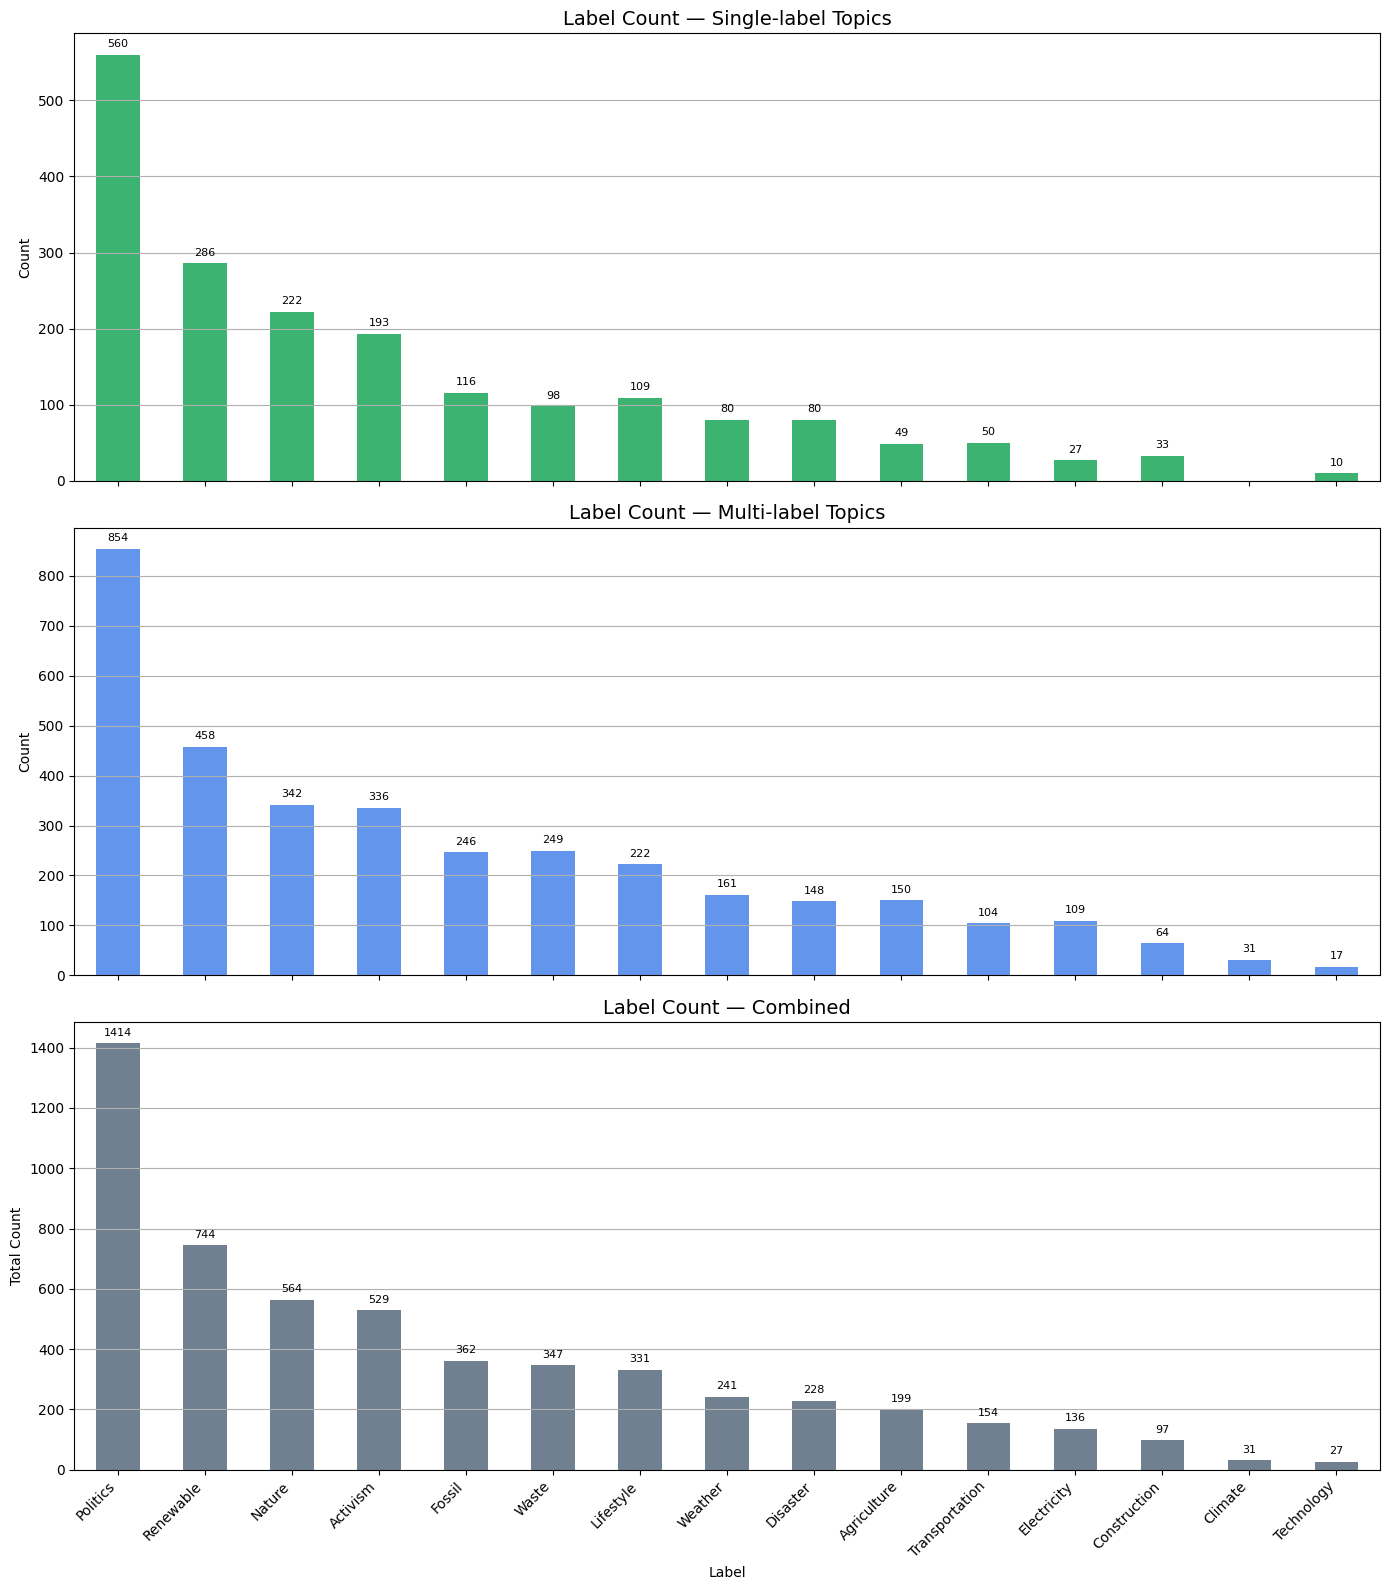

In [52]:
import matplotlib.pyplot as plt

# Helper to add value labels on bars
def annotate_bars(ax):
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{int(height)}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

# 1. Separate data
df_single = df_final[df_final["mode"] == "single_label"]
df_multi = df_final[df_final["mode"] == "multi_label"]
counts_single = df_single[labels_to_keep].sum()
counts_multi = df_multi[labels_to_keep].sum()
counts_combined = df_final[labels_to_keep].sum()

# 2. Plot setup
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# --- Single Label Plot ---
ax = axes[0]
counts_single.plot(kind="bar", ax=ax, color="mediumseagreen")
ax.set_title("Label Count — Single-label Topics", fontsize=14)
ax.set_ylabel("Count")
ax.grid(axis="y")
annotate_bars(ax)

# --- Multi Label Plot ---
ax = axes[1]
counts_multi.plot(kind="bar", ax=ax, color="cornflowerblue")
ax.set_title("Label Count — Multi-label Topics", fontsize=14)
ax.set_ylabel("Count")
ax.grid(axis="y")
annotate_bars(ax)

# --- Combined Plot ---
ax = axes[2]
counts_combined.plot(kind="bar", ax=ax, color="slategray")
ax.set_title("Label Count — Combined", fontsize=14)
ax.set_ylabel("Total Count")
ax.set_xlabel("Label")
ax.grid(axis="y")
annotate_bars(ax)

# Final formatting
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/f3/z043mppd07z6npdj2ch2t1mm0000gn/T/ipykernel_83989/1255842095.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Red → Yellow → Green


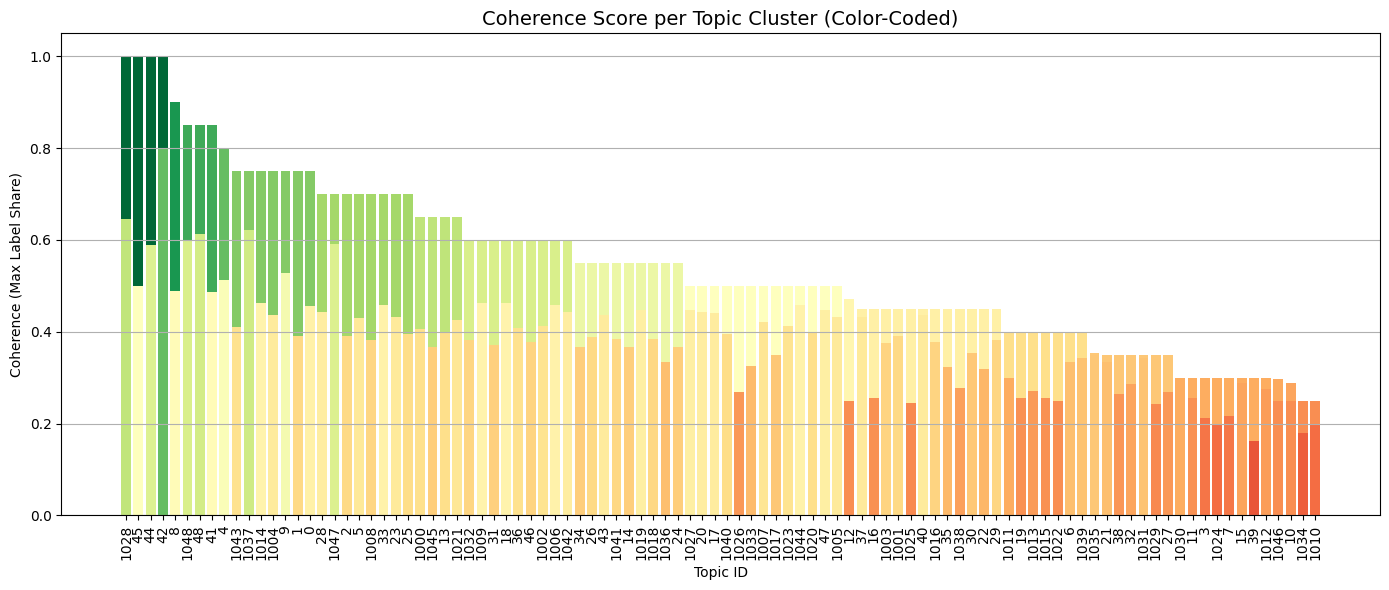

In [61]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Filter (optional)
df_sorted_coh = df_final.sort_values(by="coherence", ascending=False)

# Normalize coherence values for color mapping
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap('RdYlGn')  # Red → Yellow → Green
colors = [cmap(norm(val)) for val in df_sorted_coh["coherence"]]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df_sorted_coh["topic"].astype(str), df_sorted_coh["coherence"], color=colors)
plt.title("Coherence Score per Topic Cluster (Color-Coded)", fontsize=14)
plt.xlabel("Topic ID")
plt.ylabel("Coherence (Max Label Share)")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


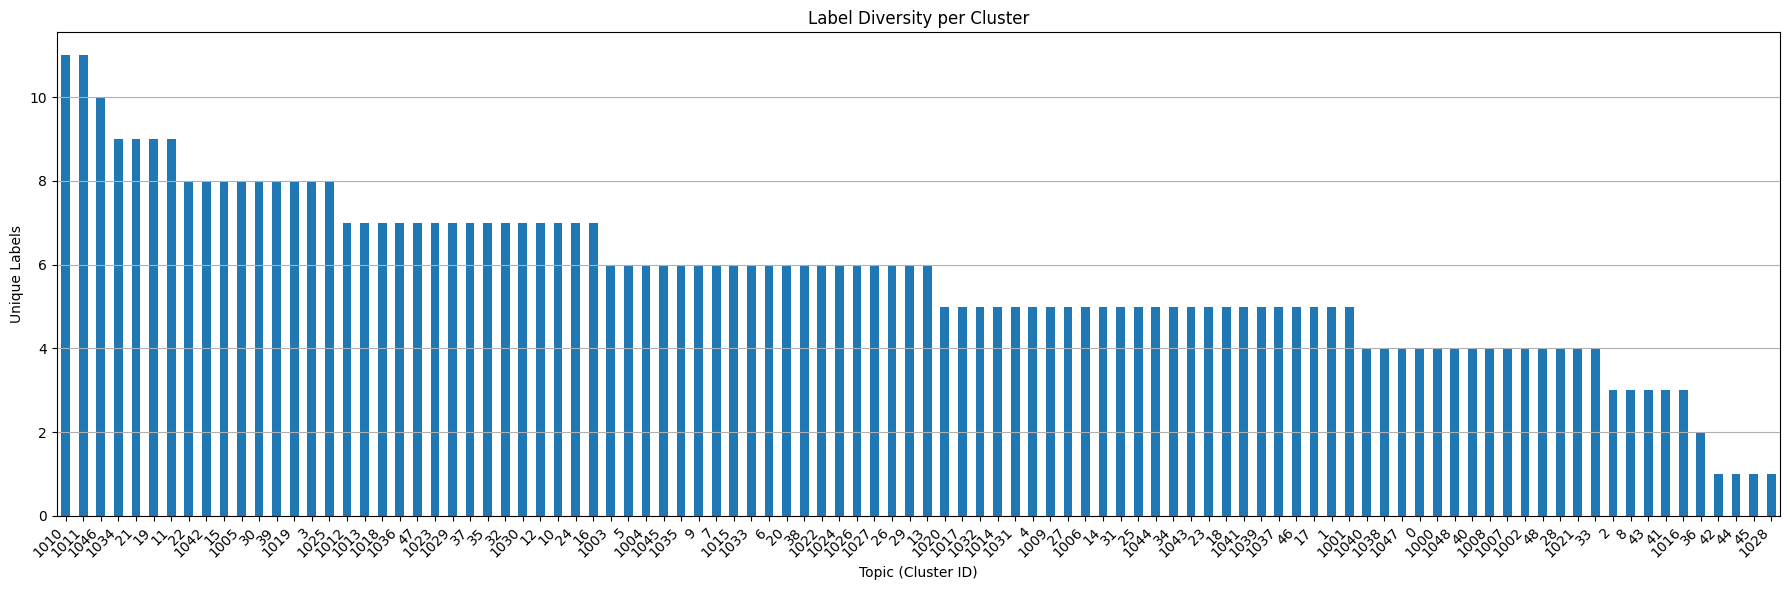

In [53]:
# Calculate diversity (number of unique labels per topic)
diversity = df_dist.groupby("topic")["label"].nunique().sort_values(ascending=False)

plt.figure(figsize=(18, 6))
diversity.plot(kind="bar")
plt.title("Label Diversity per Cluster")
plt.xlabel("Topic (Cluster ID)")
plt.ylabel("Unique Labels")
plt.xticks(rotation=45, ha="right")  # Hide x-axis labels if too many
plt.tight_layout()
plt.grid(axis="y")
plt.show()


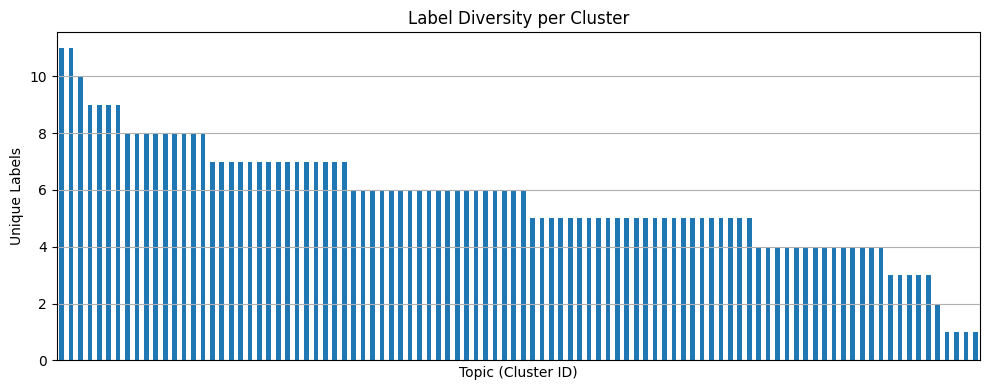

In [20]:
# Calculate diversity (number of unique labels per topic)
diversity = df_dist.groupby("topic")["label"].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
diversity.plot(kind="bar")
plt.title("Label Diversity per Cluster")
plt.xlabel("Topic (Cluster ID)")
plt.ylabel("Unique Labels")
plt.xticks([], [])  # Hide x-axis labels if too many
plt.tight_layout()
plt.grid(axis="y")
plt.show()
